In [11]:
from NetworkStructure import Generator
from NetworkStructure import Discriminator
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from torch.autograd import Variable
from torch.functional import Tensor
from torchvision import transforms
from torch import nn
import torch
import torchextractor as tx
import torchvision
%matplotlib inline
import torch

In [16]:
# parameters
image_size = 28
img_shape = 1,28,28
latent_dim = 100
image_channel = 1
batch_size = 1

In [17]:
data_transform = transforms.Compose(
    [
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)

train_dataset = torchvision.datasets.MNIST("./data", train=True, download=True,transform=data_transform)
# test_dataset = torchvision.datasets.MNIST("./data", train=False,download=True,transform=data_transform)
# min_test = torch.utils.data.Subset(test_dataset, torch.arange(1000))
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= batch_size,
    num_workers=2,
    shuffle=True,
    drop_last=True,
)

# train_data = enumerate(train_dataloader)
# a = next(train_data)
# a[1][0].shape
# enumerate = tuple(0,data) tuple(1,data) tuple(number,data)
# iter = list[data]
# data = list[data,label]
train_data = iter(train_dataloader)
# a = next(train_data)
# a[0].shape

In [30]:
# Prepare noisy Data
# get fist batch to train
real_images, label = next(train_data)
noisy = Variable(Tensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))))
# we can't create noisy at first, because the last batch may be smaller than batch_size
real_images.shape, noisy.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 100]))

In [18]:
PATH_G = "./pre-train/checkpoint389G"
PATH_D = "./pre-train/checkpoint389D"
checkpoint_G = torch.load(PATH_G)
checkpoint_D = torch.load(PATH_D)
model_G = Generator(image_size, latent_dim, image_channel)
model_D = Discriminator(image_channel)
model_G.load_state_dict(checkpoint_G['model_state_dict']) # print every layer name
model_D.load_state_dict(checkpoint_D['model_state_dict'])
model_G.eval()
model_D.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [19]:
# Function using to calculate Lapula matrix
def Lapula(feature, number, nor=False):
    """
    Calculate lapula metrix
    :param feature: input the feature
    :param number:  the number of feature
    :param nor:  default is False, if true Lapula matrix will be normalize
    :return:  lapura or sys lapula
    """
    # 1. Calcute the Similarity matrix and Degree matrix
    similarity_martix = np.empty((number,number),dtype=float)
    d_matrix = np.zeros((number,number))
    for i in range(feature.shape[0]):
        x1 = feature[i]
        for r  in range(i,feature.shape[0]):
            if i == r:
                similarity_martix[i][r] = 0
            else:
                x2 = feature[r]
                weight = torch.nn.functional.cosine_similarity(x1,x2,0).detach().numpy()
                # print(weight)
                if weight >= 0.7:
                    d_matrix[i][i] += 1
                    similarity_martix[i][r]= 1-weight
                    similarity_martix[r][i]= 1-weight
                else:
                    similarity_martix[i][r]= 0
                    similarity_martix[r][i]= 0
    lapula = d_matrix - similarity_martix
    if nor==True:
         t = np.sum(d_matrix, axis= 1)
         V = np.diag(t**(-0.5))
         where_are_inf = np.isinf(V)
         V[where_are_inf] = 0
         lapula = V@lapula@V

    return lapula

In [26]:
data = next(train_data)
data[0].shape, data[1].shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [27]:
# show layer name in model
G_name_list = tx.list_module_names(model_G)
D_name_list = tx.list_module_names(model_D)
G_name_list,D_name_list

(['',
  'l1',
  'l1.0',
  'conv_blocks',
  'conv_blocks.0',
  'conv_blocks.1',
  'conv_blocks.2',
  'conv_blocks.3',
  'conv_blocks.4',
  'conv_blocks.5',
  'conv_blocks.6',
  'conv_blocks.7',
  'conv_blocks.8',
  'conv_blocks.9',
  'conv_blocks.10'],
 ['',
  'model',
  'model.0',
  'model.1',
  'model.2',
  'model.3',
  'model.4',
  'model.5',
  'model.6',
  'model.7',
  'model.8',
  'model.9',
  'model.10',
  'model.11',
  'model.12',
  'model.13',
  'model.14',
  'adv_layer',
  'adv_layer.0',
  'adv_layer.1'])

In [28]:
# Specify the intermediate layer to be extracted
layer_G = tx.Extractor(model_G, ["conv_blocks.7"])
layer_D = tx.Extractor(model_D, ["model.11"])
layer_D,layer_G

(Extractor(
   (model): Discriminator(
     (model): Sequential(
       (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Dropout2d(p=0.25, inplace=False)
       (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (4): LeakyReLU(negative_slope=0.2, inplace=True)
       (5): Dropout2d(p=0.25, inplace=False)
       (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
       (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (8): LeakyReLU(negative_slope=0.2, inplace=True)
       (9): Dropout2d(p=0.25, inplace=False)
       (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
       (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (12): LeakyReLU(negative_slope=0.2, inplace=True)
       (13): Dropout2d(p=0.25, inplace=False)
       (14): BatchNorm2d(128, eps=0

In [36]:
# extract model layer and get final result
# get feature map in the model
gen_img, p = layer_G(noisy,image_size,latent_dim)
lable_real, q = layer_D(real_images)
label_fake, r = layer_D(gen_img)
x = real_images
y = gen_img
fp_G = p["conv_blocks.7"] # feature map in generator 100 should be a parameter(100,64,28,28)
fp_RD = q["model.11"]   # real image feature map in discriminator(100,128,2,2)
fp_FD = r["model.11"]    # fake image feature map in discriminator
# gen_img.shape, label_fake.shape, lable_real.shape
fp_G.shape, fp_FD.shape, fp_RD.shape

(torch.Size([1, 64, 28, 28]),
 torch.Size([1, 128, 2, 2]),
 torch.Size([1, 128, 2, 2]))

In [38]:
feature_map = fp_G.squeeze()
feature_map.shape, feature_map

(torch.Size([64, 28, 28]),
 tensor([[[-1.0761e-01, -1.2602e-01, -1.2646e-01,  ..., -6.2875e-02,
           -5.4831e-02, -6.9094e-02],
          [-1.6978e-01, -2.1704e-01, -1.7523e-01,  ..., -8.4729e-02,
           -5.1808e-02, -6.5161e-02],
          [-1.6812e-01, -2.1392e-01, -1.7756e-01,  ..., -9.4742e-02,
           -4.3198e-02, -6.0152e-02],
          ...,
          [ 2.4883e-02,  2.3514e-01,  1.9436e-01,  ..., -2.9113e-01,
           -3.1795e-01, -2.0354e-01],
          [-4.5404e-02,  6.6265e-02,  6.5637e-02,  ..., -2.7911e-01,
           -2.9602e-01, -1.9108e-01],
          [-9.6430e-02, -7.2642e-02, -6.0554e-02,  ..., -1.9827e-01,
           -2.1935e-01, -1.7033e-01]],
 
         [[-1.1246e-01, -2.1246e-01, -1.9857e-01,  ...,  2.3866e-01,
           -3.9592e-03, -2.7000e-02],
          [-2.3597e-01, -1.9898e-01, -1.1842e-01,  ..., -1.3961e-02,
           -7.3809e-02, -1.1486e-01],
          [-2.6732e-01, -2.2642e-01, -7.5273e-02,  ...,  2.4760e-02,
           -9.7462e-02, -1.551

In [50]:
pixel_matrix = np.empty((28*28,64),dtype=float)
img = feature_map[63,:,:]
img

tensor([[ 9.4369e-02,  3.0262e-01,  1.0926e-01, -3.8229e-02, -1.9867e-02,
         -3.7250e-03, -4.0667e-02, -1.8109e-02, -7.1330e-03,  1.0705e-01,
          3.2419e-01,  4.7300e-01,  3.7063e-01,  6.3410e-01,  5.7043e-01,
          5.8309e-01,  7.5920e-01,  7.9114e-01,  9.2384e-01,  9.3998e-01,
          1.0085e+00,  7.2787e-01,  7.1450e-01,  7.4326e-01,  5.6788e-01,
          2.7324e-01,  6.5073e-02,  9.7611e-02],
        [ 5.7674e-01,  5.1066e-01,  1.9125e-01, -2.5366e-02, -4.2182e-02,
         -9.2979e-02, -1.4857e-01, -1.5847e-01, -1.4121e-01, -4.2022e-02,
          3.9370e-01,  1.0306e+00,  9.9937e-01,  1.0604e+00,  1.1230e+00,
          9.4240e-01,  1.0961e+00,  1.3472e+00,  1.4930e+00,  1.3163e+00,
          1.1867e+00,  7.0457e-01,  4.6669e-01,  5.9703e-01,  3.9487e-01,
          4.2613e-01,  1.7720e-01,  3.3853e-01],
        [ 8.2157e-01,  6.1698e-01,  2.4336e-01, -4.6614e-02, -6.6718e-02,
         -1.3302e-01, -1.7091e-01, -1.6234e-01, -1.2691e-01,  1.0342e-01,
          5.80

In [45]:
for i in range(feature_map.shape[0]):
    for t in range(28):
        for v in range(28):
            pixel_matrix[t+v,i] = feature_map[i,t,v]

In [48]:
pixel_matrix

array([[-1.07614651e-01, -1.12462662e-01, -6.31382838e-02, ...,
        -1.95367739e-01,  4.43696201e-01,  9.43686143e-02],
       [-1.69781134e-01, -2.35971570e-01, -7.98403397e-02, ...,
        -1.69773415e-01,  6.85731173e-01,  5.76738656e-01],
       [-1.68121025e-01, -2.67323315e-01, -7.53728077e-02, ...,
        -1.63595617e-01,  5.89173198e-01,  8.21569264e-01],
       ...,
       [-3.98023230e-08, -2.91499552e-08, -5.50414709e-07, ...,
         4.03958266e-07,  9.46340111e-10, -2.50409958e-09],
       [-1.60540565e-07, -8.11832259e-13, -4.15015174e-14, ...,
         3.99140233e-04,  6.63595640e-07,  6.31018448e-03],
       [ 8.87499189e-03,  2.63807887e-04,  2.55044885e-02, ...,
         4.89492433e-07, -3.16253477e-13, -1.11757166e-15]])

In [52]:
ten_Pixel = torch.from_numpy(pixel_matrix)
lapula = Lapula(ten_Pixel,28*28,True)

/tmp/ipykernel_836209/1354441053.py:32: RuntimeWarning: divide by zero encountered in power
  V = np.diag(t**(-0.5))


In [53]:
lapula.shape

(784, 784)

In [54]:
# Function using to calculate eigenvalues and eigenvector
def eigvalueAeigvector(matrix):

    lapula_ten = torch.from_numpy(matrix)
    eigenvalues, eigenvectors = torch.eig(lapula_ten, eigenvectors=True)
    return [eigenvalues,eigenvectors]

In [61]:
eigenvalue, eigenvector = eigvalueAeigvector(lapula)

(torch.Size([784, 2]), torch.Size([784, 784]))

In [62]:
eigenvalue.shape,eigenvector.shape

(torch.Size([784, 2]), torch.Size([784, 784]))

In [64]:
def sort(eigenvalues,eigenvectors):
    sort_value = torch.empty((eigenvalues.shape[0],2),dtype=torch.float64)
    sort_vector = torch.empty((eigenvectors.shape[0],eigenvectors.shape[1]),dtype=torch.float64)
    # print(sort_vector.shape)
    r = np.argsort(eigenvalues[:,0])
    # print(r)
    i = 0
    for x in iter(r):
        # print(eigenvalues[x,0:2])
        sort_value[i,:]= eigenvalues[x,:]
        sort_vector[:,i] = eigenvectors[:,x]
        # sort_value[i,1]= eigenvalues[x,1]
        i += 1
    return sort_value, sort_vector

In [65]:
s_eigenvalue, s_eigenvector = sort(eigenvalue,eigenvector)

In [111]:
s_eigenvalue.shape, s_eigenvector.shape

(torch.Size([784, 2]), torch.Size([784, 784]))

In [160]:
img = s_eigenvector.reshape(-1,1,28,28)
img.data.shape

torch.Size([784, 1, 28, 28])

In [151]:
i_s = img.reshape(28,28)
i_s.shape

torch.Size([28, 28])

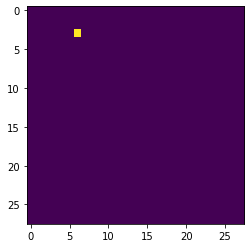

In [153]:
plt.imshow(i_s.detach().numpy().reshape(28,28))

In [163]:
from torchvision.utils import save_image

save_image(img.data[:783], "/home/athena/Pictures/GAN1/visual/real image/real5656.png" ,nrow=27,normalize=True)

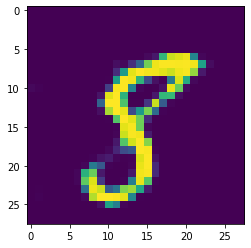

In [149]:
c = y.squeeze()
plt.imshow(c.detach().numpy())